# Object Detection with X-ray images

In [0]:
# Import libraries
!pip install pydicom
import glob, pylab, pandas as pd
import pydicom, numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import os
import cv2
import PIL # optional
import pandas as pd
import csv

# Get Data

In [0]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls

'3. Object Identification'   gdrive   sample_data


In [0]:
!unzip "/content/gdrive/My Drive/Hackathon/3. Object Identification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: 3. Object Identification/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: 3. Object Identification/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: 3. Object Identification/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: 3. Object Identification/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: 3. Object Identification/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: 3. Object Identification/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: 3. Object Identification/stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: 3. Object Identification/stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: 3. Object Identification/stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: 3. Object Identifi

In [0]:
!ls

'3. Object Identification'   gdrive   sample_data


In [0]:
df = pd.read_csv('/content/3. Object Identification/stage_2_train_labels.csv')
# Healthy patient
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [0]:
df.shape

(30227, 6)

In [0]:
len(df.patientId.unique())

26684

In [0]:
# Patient with pneumonia
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


In [0]:
dcm_data.PatientID

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

In [0]:
# Inspect DCM file
patientId = df['patientId'][0]
dcm_file = '/content/3. Object Identification/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [0]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

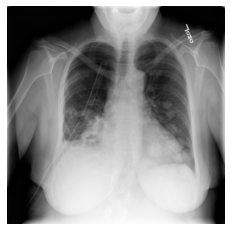

In [0]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

# Parse Data function to visualize boxes with images

In [0]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '/content/3. Object Identification/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [0]:
parsed = parse_data(df)
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': '/content/3. Object Identification/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


In [0]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object
{'No Lung Opacity / Not Normal': 11821, 'Normal': 8851, 'Lung Opacity': 9555}


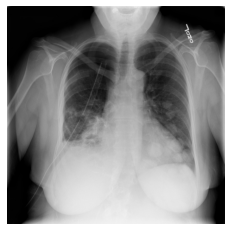

In [0]:
df_detailed = pd.read_csv('/content/3. Object Identification/stage_2_detailed_class_info.csv')
print(df_detailed.iloc[0])

patientId = df_detailed['patientId'][0]
draw(parsed[patientId])

summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print(summary)

In [0]:
df_detailed.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


# Create Data Loader Pipeline

In [0]:
df.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [0]:
df.Target.unique()

array([0, 1])

In [0]:
df_detailed.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


# Numpy arrays for Pytorch Data Loader Input

In [0]:
# Set normal patients boxes to zeros
df_box = df.copy()
df_box.fillna(0, inplace = True)

# Write to arrays for input data loader
ids = np.array(df['patientId'])
boxes = np.array((df_box['x'], df_box['y'], df_box['width'], df_box['height'])).T
labels = np.array(df['Target'])


np.save('/content/gdrive/My Drive/Hackathon/ids.npy', ids)
np.save('/content/gdrive/My Drive/Hackathon/boxes.npy', boxes)
np.save('/content/gdrive/My Drive/Hackathon/labels.npy', labels)

# Convert DCM images to PNG

In [0]:
df_boxes.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [0]:
! ls -l "/content/gdrive/My Drive/Hackathon/data_final" | wc

  26685  240158 2081365


In [0]:
import math

data_path = "/content/gdrive/My Drive/Hackathon/data_final"

df_boxes = df.dropna()
for index, row in df_boxes.iterrows():
    image_id = row['patientId']
    boxes = np.array((row['x'], row['y'], row['width'], row['height'])).T
    try:
      np.save(os.path.join(data_path, image_id,'boxes.npy'), boxes)
    except FileNotFoundError:
      print('failing', index, row)
      print(os.path.isdir(data_path +'/00704310-78a8-4b38-8475-49f4573b2dbb'))
      break


    

In [0]:
os.path.isdir('/content/gdrive/My Drive/Hackathon/data/eda49900-8110-4529-b1ed-abb154c92396/')

False

In [0]:
df[df.patientId == 'eda49900-8110-4529-b1ed-abb154c92396']

,patientId,x,y,width,height,Target
26690,eda49900-8110-4529-b1ed-abb154c92396,269.0,276.0,209.0,478.0,1
26691,eda49900-8110-4529-b1ed-abb154c92396,629.0,251.0,236.0,541.0,1


In [0]:
os.path.join(png_folder_path, image_id)

'/content/gdrive/My Drive/Hackathon/data/7a74e2ed-5942-4cbc-b5cb-84a4f5ccf105'

In [0]:
PNG = True
# Specify the .dcm folder path
folder_path = "/content/3. Object Identification/stage_2_train_images"
# Specify the .jpg/.png folder path
png_folder_path = "/content/gdrive/My Drive/Hackathon/data_final"
images_path = os.listdir(folder_path)
# images_path = images_path[26600:]
# #print(images_path)
# images_path = ['eda49900-8110-4529-b1ed-abb154c92396.dcm']
# print(images_path)
#for n, image in enumerate(images_path):
for n, image_id in enumerate(list(df['patientId'])):
    print(image_id)
    #image_id =  df['patientId'][n]
    image = str(image_id)+'.dcm'
    ds = dicom.dcmread(os.path.join(folder_path, image))
    rows = []
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    # try:
    #   os.mkdir(os.path.join(png_folder_path, image_id))
    # except FileExistsError:
    #   pass
    path = png_folder_path + '/' + image_id

    if not os.path.isdir(path):
      # print(os.path.isdir(path))
      # print(path)
      os.mkdir(path)

    # if image_id== 'eda49900-8110-4529-b1ed-abb154c92396':
    #   print(os.path.isdir(os.path.join(png_folder_path, image_id)))
    #   break


    # print(os.path.join(png_folder_path, image_id))
    cv2.imwrite(path + '/image.png', pixel_array_numpy)
    # if n == 10:
    #   break
    if n % 50 == 0:
        print('{} image converted'.format(n))


Streaming output truncated to the last 5000 lines.
e2fc3d22-252a-4e95-bcf2-76c56a95ce39
e2ff4938-8485-41f5-b35b-ce6a81a6f93e
e3000385-7818-4730-98da-8285b6eeac72
e30028a5-ccf1-4afa-8cd8-5b6129483e96
e300292a-1edb-42c2-921e-7f3c507119e0
e300a4ef-a09f-4ee1-83c4-4a2d0c0c2f58
e3027475-6526-42ca-9284-2194811b5fda
e3033174-566b-40dd-b717-68bc91075647
e304f03c-1510-484e-afc0-aacec02c1b92
e30545c2-85e5-4c68-95b5-03591e123f91
e305e5a5-b0b2-4f8e-9533-ea62325004cf
e30935ce-5d14-410f-bead-9ed974d5090b
e3094e51-b690-4700-adaa-8cc4782fae87
e30bd362-7a11-4797-adb2-708520cdfb8d
e3100db8-47fb-4c88-a6d6-50129fc6085f
e31300d4-90b0-4fa3-8902-30c225b9279a
e314d288-ec1f-4fd4-81cf-b8fe0abf44bc
e319ed0d-cd63-4bd0-828e-9acca7997565
e3218078-a2e0-49f9-81b4-9d3ea3c19308
e3218c97-e918-4091-a957-d76548563f70
e321a0e5-0150-4e18-b83b-08af1e7c22b5
e32792fc-b3bc-4a0b-af37-47b989658a9f
e327e9ab-88d3-4f68-9e18-3a77fedf96e2
e327fe80-07c6-4f4c-ac0b-917f3362fbdd
e3295022-dbdb-4dc1-8b9a-e929df6844ad
25350 image converted
e3

In [0]:
!ls '/content/gdrive/My Drive/Hackathon/data/312920e7-f9a9-4064-aa35-96b805637bcc'

ls: cannot access '/content/gdrive/My Drive/Hackathon/data/312920e7-f9a9-4064-aa35-96b805637bcc': No such file or directory


In [0]:
!ls '3. Object Identification/stage_2_train_images' | grep "312920e7-f9a9-4064-aa35-96b805637bcc"

312920e7-f9a9-4064-aa35-96b805637bcc.dcm


In [0]:
df.shape

(30227, 6)

# References

* https://www.kaggle.com/peterchang77/exploratory-data-analysis